## Setup

In [9]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In [2]:
train_path = "cats-and-dogs/train"
valid_path = "cats-and-dogs/valid"
test_path = "cats-and-dogs/test"

### ImageDataGenerator:
     Generates batches of tensor image data, which is the format that the keras model accepts
### flow_from_directory:
     Takes the path of the directory and generates batches and normalizes the data
     

In [23]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=["dog","cat"], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=["dog","cat"], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=["dog","cat"], batch_size=10)


Found 40 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [15]:
#plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [16]:
imgs, labels = next(train_batches)

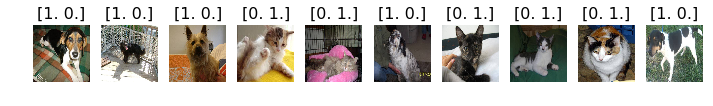

In [17]:
plots(imgs,titles=labels)

# Build and train CNN

### Conv2D: 2 Dimensional Convolutional Layer
    32: number of ouput filters
    (3,3): size of convolutional window
    input_shape(height,width, channels(RGB scale))
### Flatten():
    takes the ouput of the previous layer and flatten it into a one dimensional tensor, which is going to be fed into
    the Dense layer(next layer)

    

In [24]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    Flatten(),
    Dense(2, activation="softmax")
])

In [25]:
model.compile(Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


In [26]:
model.fit_generator(train_batches, steps_per_epoch=4, validation_data=valid_batches,
                   validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 4s - loss: 8.4620 - acc: 0.4750 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 3s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
 - 3s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
 - 3s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
 - 3s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000


# Predict

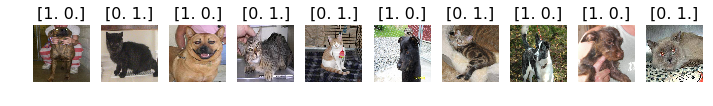

In [30]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [31]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)

In [32]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
predictions

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Confusion matrix, without normalization
[[5 0]
 [5 0]]


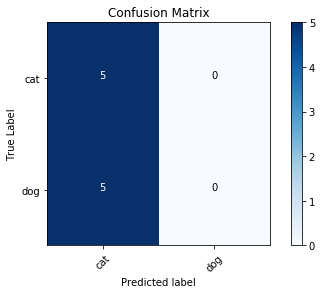

In [34]:
cm = confusion_matrix(test_labels, predictions[:,0])

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title="Confusion matrix",
                         cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if(normalize):
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j], horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.xlabel("Predicted label")
    plt.ylabel("True Label")

plot_confusion_matrix(cm,['cat','dog'], title="Confusion Matrix")

# Build Fine-tuned VGG16 model 

In [54]:
vgg16_model = keras.applications.vgg16.VGG16()

In [55]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [56]:
type(vgg16_model)

keras.engine.training.Model

#### Copying the layers from the VGG16 model to a sequential model

In [61]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)


In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

#### Getting rid off of the last layer. The layer that evaluates the input with 1000 classes
## *layers.pop() currently not working

In [63]:
model.layers.pop()

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

#### Exluding the layers from future training

In [65]:
for layer in model.layers:
    layer.trainable = False

#### Adding the last layer to only evaluate in two classes

In [67]:
model.add(Dense(2,activation="softmax"))

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

# Train the fine-tuned VGG16 Model

In [69]:
model.compile(Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [72]:
model.fit_generator(train_batches, steps_per_epoch=4, validation_data=valid_batches,
                  validation_steps=4, epochs=10, verbose=2)

Epoch 1/10
 - 63s - loss: 0.1541 - acc: 0.9500 - val_loss: 0.5455 - val_acc: 0.8125
Epoch 2/10
 - 68s - loss: 0.1163 - acc: 0.9750 - val_loss: 0.5308 - val_acc: 0.8125
Epoch 3/10
 - 87s - loss: 0.0890 - acc: 0.9750 - val_loss: 0.5134 - val_acc: 0.8125
Epoch 4/10
 - 88s - loss: 0.0741 - acc: 1.0000 - val_loss: 0.4941 - val_acc: 0.8125
Epoch 5/10
 - 85s - loss: 0.0595 - acc: 1.0000 - val_loss: 0.4835 - val_acc: 0.8125
Epoch 6/10
 - 87s - loss: 0.0507 - acc: 1.0000 - val_loss: 0.4753 - val_acc: 0.8125
Epoch 7/10
 - 84s - loss: 0.0431 - acc: 1.0000 - val_loss: 0.4712 - val_acc: 0.8125
Epoch 8/10
 - 85s - loss: 0.0371 - acc: 1.0000 - val_loss: 0.4739 - val_acc: 0.8125
Epoch 9/10
 - 87s - loss: 0.0331 - acc: 1.0000 - val_loss: 0.4733 - val_acc: 0.8125
Epoch 10/10
 - 87s - loss: 0.0296 - acc: 1.0000 - val_loss: 0.4749 - val_acc: 0.8125


# Predict using fine-tuned VGG16 Model

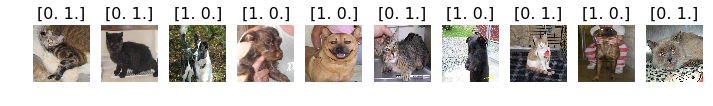

In [73]:
test_imgs, test_labels = next(test_batchesatchesatches)
plots(test_imgs, titles=test_labels)

In [74]:
test_labels = test_labels[:,0]
test_labels

array([0., 0., 1., 1., 1., 0., 1., 0., 1., 0.], dtype=float32)

In [75]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [77]:
cm = confusion_matrix(test_labels,np.round(predictions[:,0]))

Confusion matrix, without normalization
[[5 0]
 [1 4]]


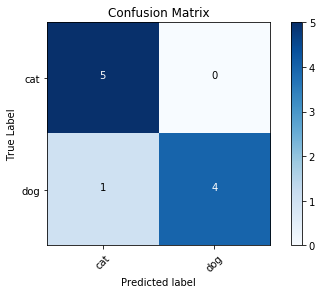

In [79]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title="Confusion Matrix")